In [1]:
# Install required packages for analysis
# Uncomment and run if packages are missing:

# %pip install pandas matplotlib seaborn numpy scipy scikit-learn jupyter

# Or install from requirements file:
# %pip install -r ../requirements.txt

# Check if all packages are available
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy import stats
    from sklearn.preprocessing import StandardScaler
    print("✓ All required packages are installed and available")
except ImportError as e:
    print(f"✗ Missing package: {e}")
    print("Please uncomment and run the pip install commands above")


✓ All required packages are installed and available


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Configure plotting parameters for academic presentation
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

print("Analysis environment initialized successfully")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")


Analysis environment initialized successfully
pandas version: 2.3.0
numpy version: 2.2.6


In [3]:
# Load the most recent story generation results
results_dir = Path('../results/story_generation')
csv_files = list(results_dir.glob('story_generation_results_*.csv'))

if not csv_files:
    raise FileNotFoundError("No story generation results found. Please run 02_story_generation_collect.py first.")

# Use the most recent results file
latest_file = max(csv_files, key=lambda x: x.stat().st_mtime)
print(f"Loading data from: {latest_file.name}")

# Load the dataset
df = pd.read_csv(latest_file)

print(f"Dataset loaded successfully")
print(f"Total records: {len(df)}")
print(f"Unique models: {df['story_model'].nunique()}")
print(f"Unique images: {df['image_file'].nunique()}")
print(f"Date range: {latest_file.stat().st_mtime}")


Loading data from: story_generation_results_20250611_161706.csv
Dataset loaded successfully
Total records: 128
Unique models: 8
Unique images: 16
Date range: 1749648562.8948827


In [4]:
# Data exploration and basic information
print("=== DATASET CHARACTERIZATION ===\n")

print("Story generation models evaluated:")
for model in df['story_model'].unique():
    print(f"  - {model}")

print(f"\nTest images:")
for image in df['image_file'].unique():
    print(f"  - {image}")

print(f"\nData completeness assessment:")
expected_combinations = len(df['story_model'].unique()) * len(df['image_file'].unique())
print(f"  - Expected combinations: {len(df['story_model'].unique())} models × {len(df['image_file'].unique())} images = {expected_combinations}")
print(f"  - Actual records: {len(df)}")
print(f"  - Missing records: {expected_combinations - len(df)}")

# Data quality assessment
print(f"\nData quality assessment:")
print(df.isnull().sum())

# Display dataset structure
print(f"\nDataset columns:")
print(list(df.columns))
print(f"\nSample data:")
df.head()


=== DATASET CHARACTERIZATION ===

Story generation models evaluated:
  - gpt-4o
  - gpt-4o-mini
  - claude-3.5-sonnet
  - claude-3.5-haiku
  - gemini-2.0-flash
  - gemini-2.0-flash-lite
  - gemini-1.5-pro
  - gemini-1.5-flash

Test images:
  - toy_01.jpeg
  - toy_02.jpeg
  - toy_03.jpeg
  - toy_04.jpeg
  - toy_05.jpeg
  - toy_06.jpeg
  - toy_07.jpeg
  - toy_08.jpeg
  - toy_09.jpeg
  - toy_10.jpeg
  - drawing_01.jpeg
  - drawing_02.jpeg
  - drawing_03.jpeg
  - drawing_04.jpeg
  - drawing_05.jpeg
  - drawing_06.jpeg

Data completeness assessment:
  - Expected combinations: 8 models × 16 images = 128
  - Actual records: 128
  - Missing records: 0

Data quality assessment:
image_file           0
image_type           0
image_caption        0
story_model          0
generated_story      0
execution_time       0
cost                 0
word_count           0
quality_score        0
meets_length_req     0
has_title            0
contains_dialogue    0
positive_tone        0
story_structure      0


,image_file,image_type,image_caption,story_model,generated_story,execution_time,cost,word_count,quality_score,meets_length_req,has_title,contains_dialogue,positive_tone,story_structure,age_appropriate,bedtime_suitable
0,toy_01.jpeg,toy,A doll with curly blonde hair and a red jumpsu...,gpt-4o,Title: The Little Doll's Big Adventure\n\nOnce...,8.99,0.004430,201,26.00,True,True,True,True,True,True,True
1,toy_01.jpeg,toy,A doll with curly blonde hair and a red jumpsu...,gpt-4o-mini,Title: Bella and the Cozy Couch\n\nOnce upon a...,4.91,0.000165,182,23.62,True,True,True,True,True,True,True
2,toy_01.jpeg,toy,A doll with curly blonde hair and a red jumpsu...,claude-3.5-sonnet,Title: Sarah's Special Spot\n\nSarah the doll ...,6.19,0.003816,195,25.25,True,True,True,True,True,True,True
3,toy_01.jpeg,toy,A doll with curly blonde hair and a red jumpsu...,claude-3.5-haiku,Title: Rosie's Cozy Afternoon\n\nEmma loved he...,6.78,0.000990,173,22.50,True,True,True,True,True,True,True
4,toy_01.jpeg,toy,A doll with curly blonde hair and a red jumpsu...,gemini-2.0-flash,"Title: Rosie's Cozy Corner\n\nRosie, the doll ...",2.61,0.000338,177,22.88,True,True,True,True,True,False,True


In [5]:
## 2. Performance Metrics Analysis


In [6]:
# Performance statistics by model
print("=== PERFORMANCE METRICS ANALYSIS ===\n")

# Aggregate performance statistics by model
performance_stats = df.groupby('story_model').agg({
    'execution_time': ['mean', 'std', 'min', 'max'],
    'cost': ['mean', 'std', 'min', 'max']
}).round(4)

performance_stats.columns = ['_'.join(col) for col in performance_stats.columns]
print("Performance Statistics by Model:")
print(performance_stats)

# Calculate efficiency metrics
print("\n=== EFFICIENCY METRICS ===")
efficiency_metrics = df.groupby('story_model').agg({
    'execution_time': 'mean',
    'cost': 'mean'
}).round(4)

# Add cost per second metric
efficiency_metrics['cost_per_second'] = (efficiency_metrics['cost'] / efficiency_metrics['execution_time']).round(6)
efficiency_metrics['speed_rank'] = efficiency_metrics['execution_time'].rank()
efficiency_metrics['cost_rank'] = efficiency_metrics['cost'].rank()

print("Efficiency Rankings:")
print(efficiency_metrics.sort_values('execution_time'))


=== PERFORMANCE METRICS ANALYSIS ===

Performance Statistics by Model:
                       execution_time_mean  execution_time_std  \
story_model                                                      
claude-3.5-haiku                    7.3562              0.7990   
claude-3.5-sonnet                   6.8006              0.4837   
gemini-1.5-flash                    2.0275              0.1062   
gemini-1.5-pro                      5.8894              0.4173   
gemini-2.0-flash                    2.3406              0.2125   
gemini-2.0-flash-lite               2.0625              0.1541   
gpt-4o                             11.0375              3.7729   
gpt-4o-mini                         5.4975              0.8033   

                       execution_time_min  execution_time_max  cost_mean  \
story_model                                                                
claude-3.5-haiku                     5.94                8.37     0.0010   
claude-3.5-sonnet                    6.0

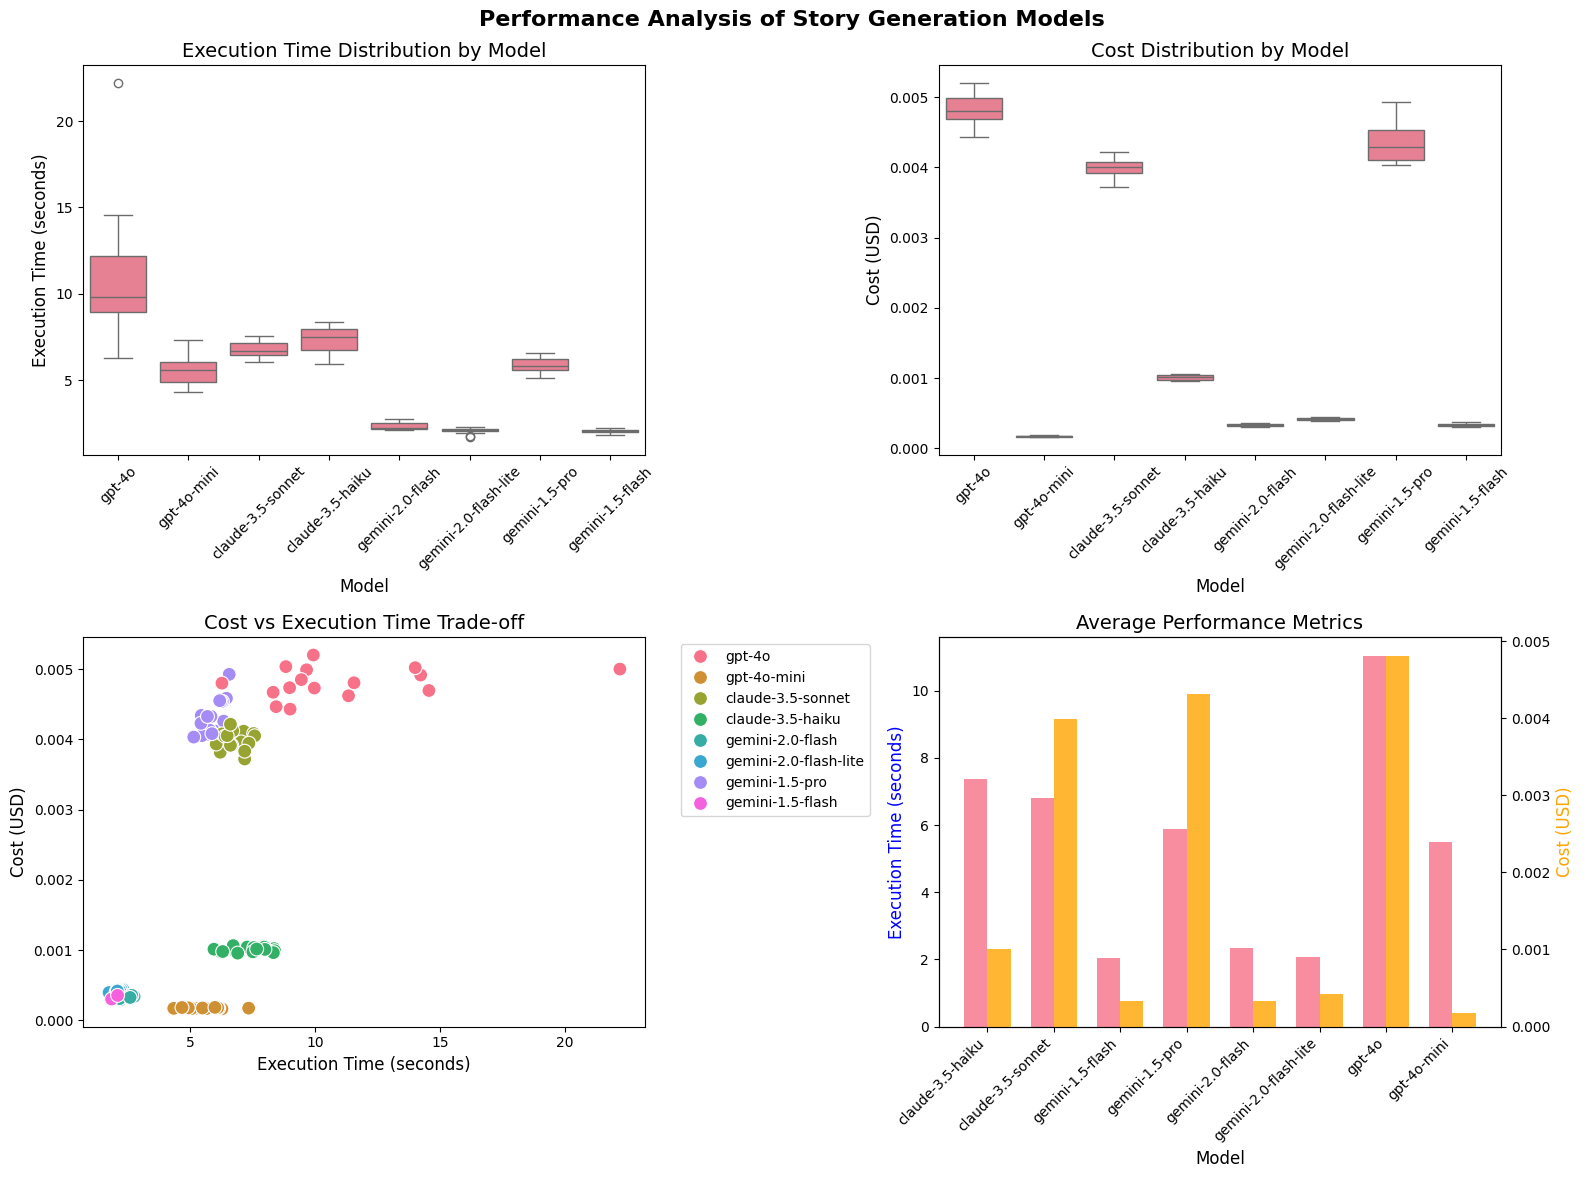

In [7]:
# Performance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Analysis of Story Generation Models', fontsize=16, fontweight='bold')

# Execution time analysis
sns.boxplot(data=df, x='story_model', y='execution_time', ax=axes[0,0])
axes[0,0].set_title('Execution Time Distribution by Model')
axes[0,0].set_xlabel('Model')
axes[0,0].set_ylabel('Execution Time (seconds)')
axes[0,0].tick_params(axis='x', rotation=45)

# Cost analysis
sns.boxplot(data=df, x='story_model', y='cost', ax=axes[0,1])
axes[0,1].set_title('Cost Distribution by Model')
axes[0,1].set_xlabel('Model')
axes[0,1].set_ylabel('Cost (USD)')
axes[0,1].tick_params(axis='x', rotation=45)

# Cost vs execution time relationship
sns.scatterplot(data=df, x='execution_time', y='cost', hue='story_model', s=100, ax=axes[1,0])
axes[1,0].set_title('Cost vs Execution Time Trade-off')
axes[1,0].set_xlabel('Execution Time (seconds)')
axes[1,0].set_ylabel('Cost (USD)')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Average performance comparison
avg_metrics = df.groupby('story_model')[['execution_time', 'cost']].mean().reset_index()
x_pos = np.arange(len(avg_metrics))
width = 0.35

ax2 = axes[1,1]
ax2_twin = ax2.twinx()

bars1 = ax2.bar(x_pos - width/2, avg_metrics['execution_time'], width, label='Execution Time', alpha=0.8)
bars2 = ax2_twin.bar(x_pos + width/2, avg_metrics['cost'], width, label='Cost', alpha=0.8, color='orange')

ax2.set_xlabel('Model')
ax2.set_ylabel('Execution Time (seconds)', color='blue')
ax2_twin.set_ylabel('Cost (USD)', color='orange')
ax2.set_title('Average Performance Metrics')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(avg_metrics['story_model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [8]:
## 3. Story Quality Analysis


In [9]:
# First, identify the correct column name for story content
print("Available columns:", df.columns.tolist())
print("\nSample of first few rows:")
print(df.head(2))

# Identify the story content column (likely 'story', 'content', 'generated_story', etc.)
story_col = None
for col in df.columns:
    if 'story' in col.lower() or 'content' in col.lower() or 'text' in col.lower():
        if df[col].dtype == 'object' and df[col].str.len().mean() > 50:  # Likely contains story text
            story_col = col
            break

if story_col is None:
    # Try to find any text column with substantial content
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                if df[col].str.len().mean() > 50:
                    story_col = col
                    break
            except:
                continue

print(f"\nUsing column '{story_col}' as story content")

# Enhanced story quality metrics calculation
df['story_length'] = df[story_col].str.len()
df['word_count'] = df[story_col].str.split().str.len()
df['sentence_count'] = df[story_col].str.count('\.') + df[story_col].str.count('\!') + df[story_col].str.count('\?')

# Readability metrics
df['avg_words_per_sentence'] = df['word_count'] / df['sentence_count'].replace(0, 1)
df['avg_chars_per_word'] = df['story_length'] / df['word_count'].replace(0, 1)

# Simple readability score (lower is easier to read)
# Based on average sentence length and word complexity
df['readability_score'] = (df['avg_words_per_sentence'] * 0.39) + (df['avg_chars_per_word'] * 11.8) - 15.59

# Calculate basic quality metrics
quality_metrics = df.groupby('story_model').agg({
    'story_length': ['mean', 'std'],
    'word_count': ['mean', 'std'],
    'sentence_count': ['mean', 'std'],
    'avg_words_per_sentence': ['mean', 'std'],
    'readability_score': ['mean', 'std']
}).round(2)

quality_metrics.columns = ['_'.join(col) for col in quality_metrics.columns]
print("=== STORY QUALITY ANALYSIS ===\n")
print("Story Length and Structure Statistics:")
print(quality_metrics)

# Enhanced content analysis for children's stories
print(f"\n=== COMPREHENSIVE CONTENT ANALYSIS ===\n")

# Age Appropriateness Indicators
age_appropriate_indicators = {
    'gentle_themes': df[story_col].str.contains('bedtime|sleep|dream|adventure|play|toy|animal|forest|garden|friend', case=False, na=False),
    'positive_emotions': df[story_col].str.contains('happy|joy|smile|laugh|excited|cheerful|delighted|pleased', case=False, na=False),
    'no_scary_content': ~df[story_col].str.contains('death|die|kill|monster|scary|frightening|terrifying|nightmare', case=False, na=False),
    'family_friendly': df[story_col].str.contains('family|parent|mom|dad|brother|sister|grandma|grandpa', case=False, na=False),
    'moral_lessons': df[story_col].str.contains('learn|lesson|important|remember|always|never give up|be kind|help others', case=False, na=False)
}

# Readability Indicators  
readability_indicators = {
    'simple_sentences': df['avg_words_per_sentence'] <= 15,  # Age-appropriate sentence length
    'simple_vocabulary': df['avg_chars_per_word'] <= 5,     # Simple words
    'good_readability': df['readability_score'] <= 8,       # Reading level appropriate for kids
    'dialogue_present': df[story_col].str.contains('".*"', case=False, na=False),
    'repetitive_patterns': df[story_col].str.contains('again and again|over and over|every day|once more', case=False, na=False)
}

# Engagement Indicators
engagement_indicators = {
    'sensory_descriptions': df[story_col].str.contains('saw|heard|felt|touched|smelled|tasted|looked|listened|bright|loud|soft|sweet', case=False, na=False),
    'action_words': df[story_col].str.contains('ran|jumped|climbed|danced|sang|played|laughed|explored|discovered|found', case=False, na=False),
    'character_emotions': df[story_col].str.contains('felt|emotion|happy|sad|excited|worried|surprised|amazed|proud|grateful', case=False, na=False),
    'interactive_elements': df[story_col].str.contains('what do you think|can you|let\'s|imagine|picture this', case=False, na=False),
    'imaginative_elements': df[story_col].str.contains('magical|fantasy|wonder|amazing|incredible|special|extraordinary|imagine', case=False, na=False)
}

# Story Structure Indicators
structure_indicators = {
    'clear_beginning': df[story_col].str.contains('^(Once upon|In a|There was|Long ago|One day)', case=False, na=False),
    'problem_resolution': df[story_col].str.contains('problem|trouble|difficult|challenge.*solv|fix|help|solution', case=False, na=False),
    'satisfying_ending': df[story_col].str.contains('(happily|safely|peacefully|contentedly|finally|end|home|sleep)', case=False, na=False),
    'proper_length': (df['word_count'] >= 50) & (df['word_count'] <= 300),  # Appropriate length for bedtime stories
    'character_development': df[story_col].str.contains('character.*learn|grow|change|become|realize|understand', case=False, na=False)
}

# Combine all indicators
all_indicators = {**age_appropriate_indicators, **readability_indicators, **engagement_indicators, **structure_indicators}

# Apply indicators to dataframe
for indicator, mask in all_indicators.items():
    df[indicator] = mask

# Group indicators for analysis
indicator_groups = {
    'Age Appropriateness': list(age_appropriate_indicators.keys()),
    'Readability': list(readability_indicators.keys()),
    'Engagement': list(engagement_indicators.keys()),
    'Story Structure': list(structure_indicators.keys())
}

# Analyze each group
for group_name, indicators in indicator_groups.items():
    group_analysis = df.groupby('story_model')[indicators].mean().round(3)
    print(f"\n{group_name} Analysis (proportion of stories with features):")
    print(group_analysis)
    print(f"Average {group_name} Score by Model:")
    group_scores = group_analysis.mean(axis=1).round(3)
    for model, score in group_scores.sort_values(ascending=False).items():
        print(f"  {model}: {score:.3f}")
    print()


Available columns: ['image_file', 'image_type', 'image_caption', 'story_model', 'generated_story', 'execution_time', 'cost', 'word_count', 'quality_score', 'meets_length_req', 'has_title', 'contains_dialogue', 'positive_tone', 'story_structure', 'age_appropriate', 'bedtime_suitable']

Sample of first few rows:
    image_file image_type                                      image_caption  \
0  toy_01.jpeg        toy  A doll with curly blonde hair and a red jumpsu...   
1  toy_01.jpeg        toy  A doll with curly blonde hair and a red jumpsu...   

   story_model                                    generated_story  \
0       gpt-4o  Title: The Little Doll's Big Adventure\n\nOnce...   
1  gpt-4o-mini  Title: Bella and the Cozy Couch\n\nOnce upon a...   

   execution_time      cost  word_count  quality_score  meets_length_req  \
0            8.99  0.004430         201          26.00              True   
1            4.91  0.000165         182          23.62              True   

   has_tit

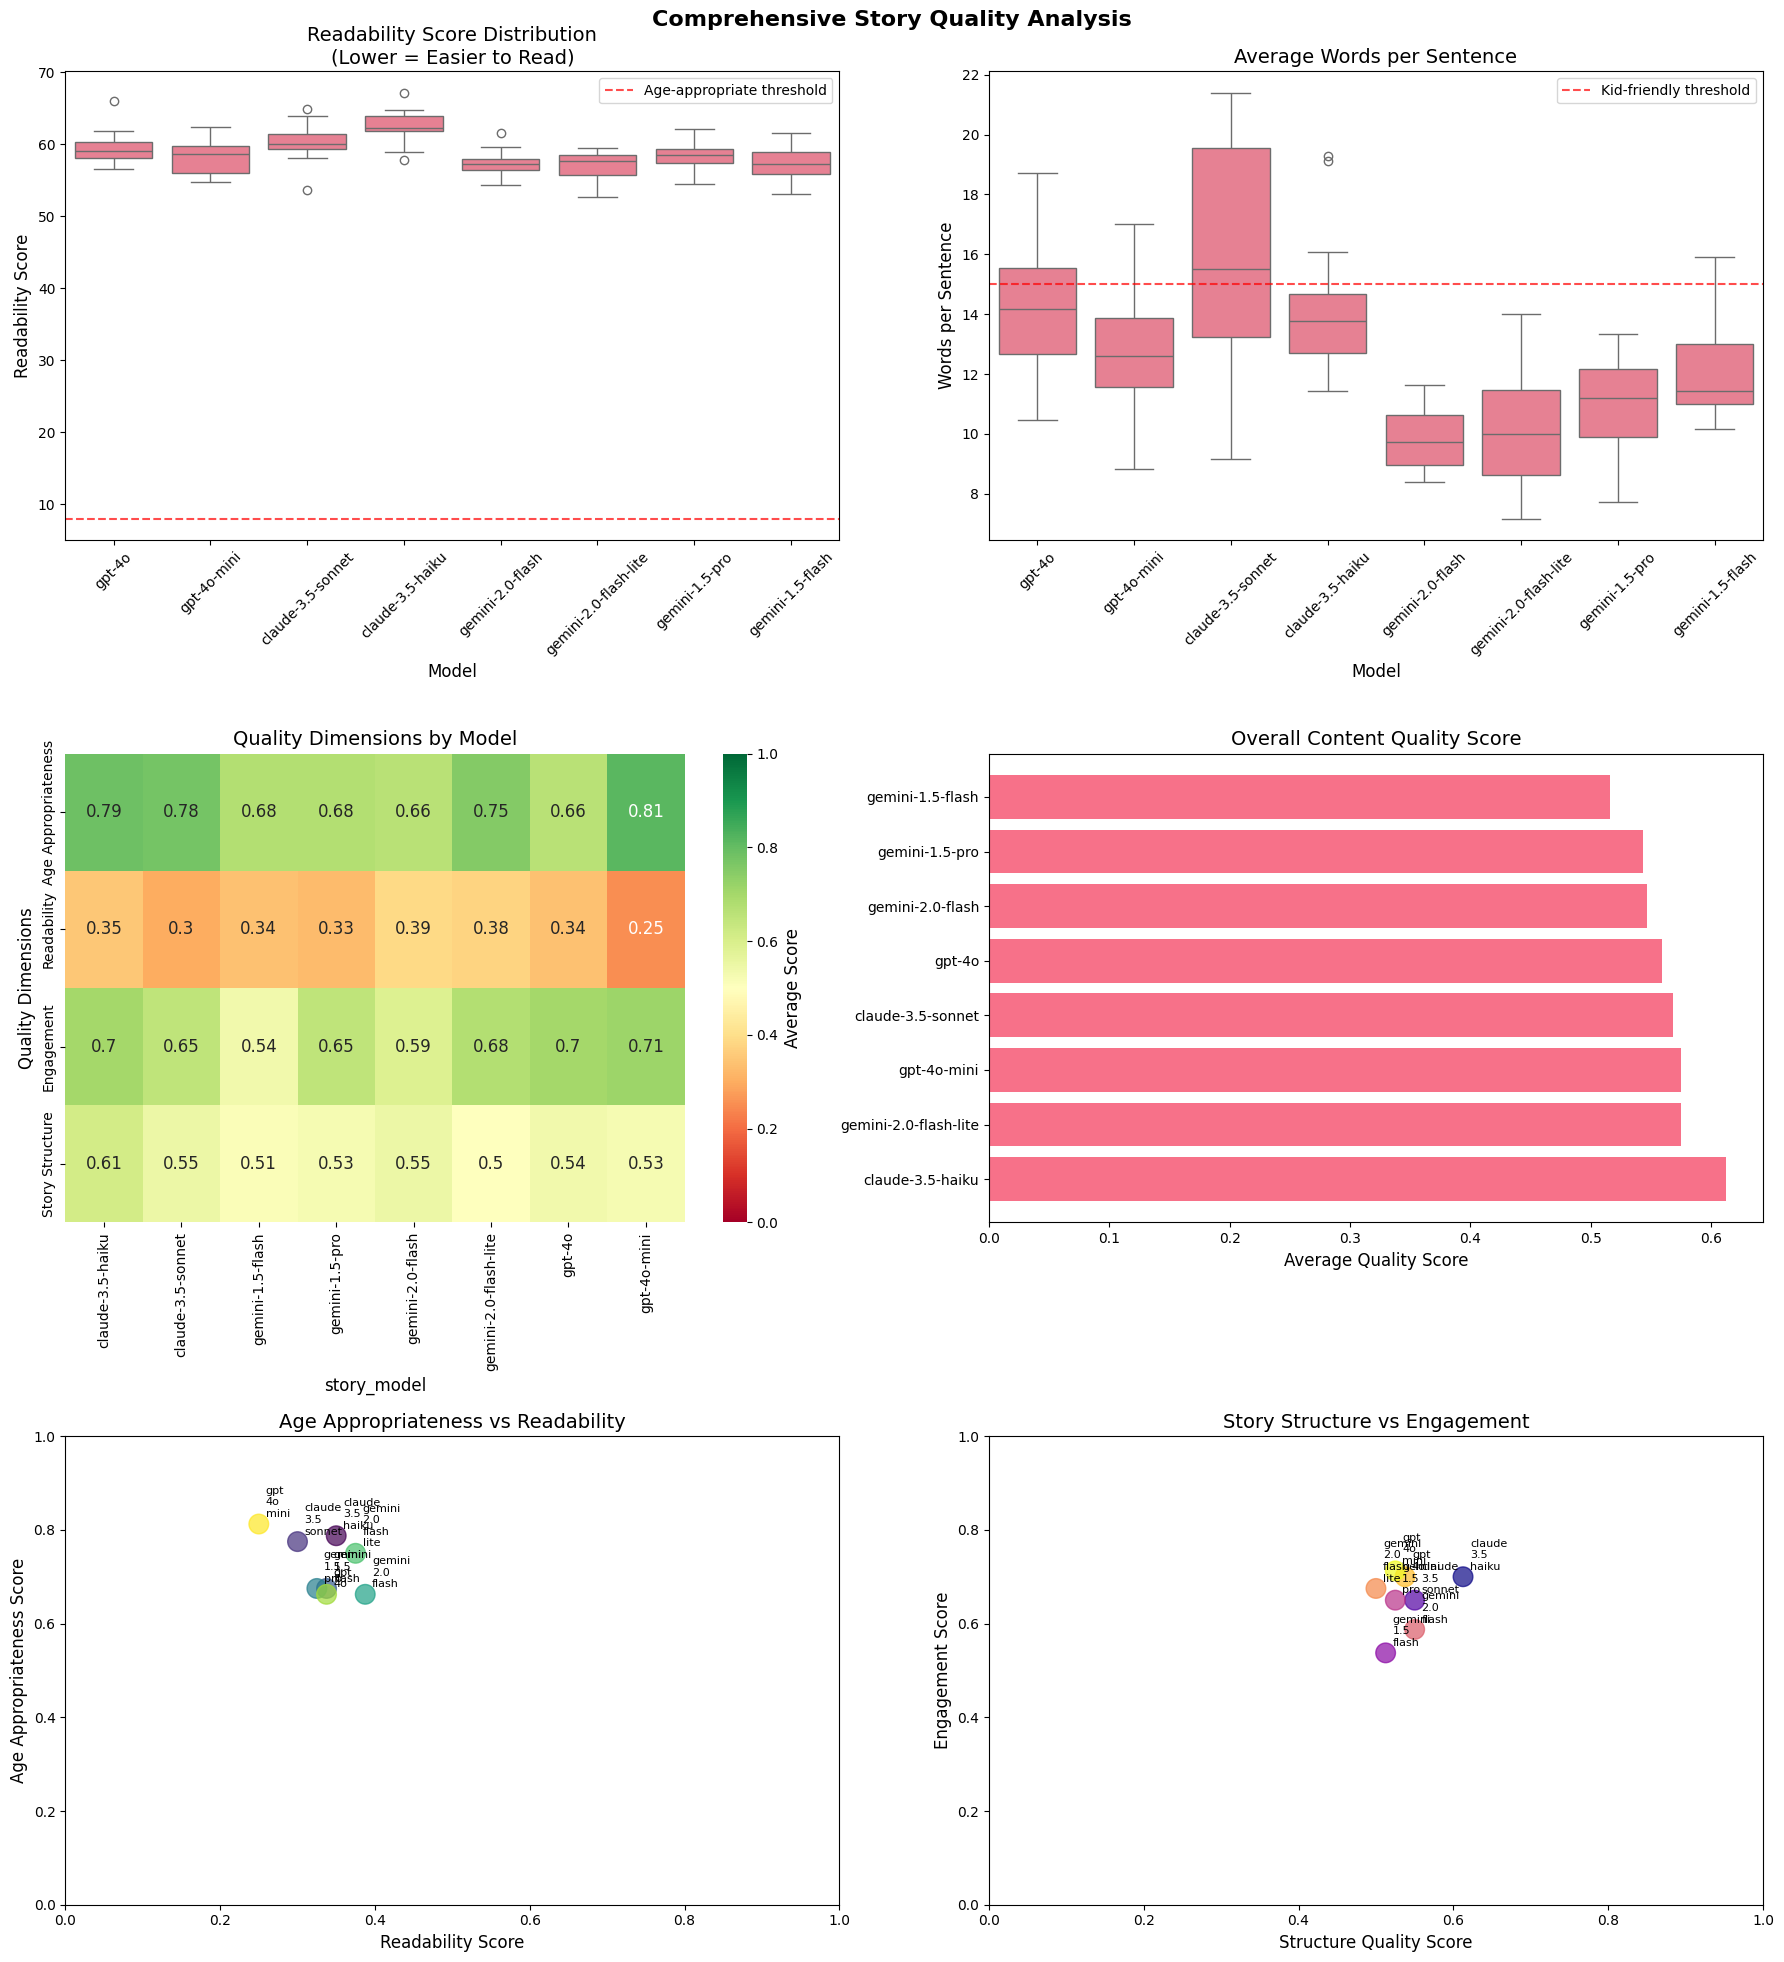


=== QUALITY DIMENSION ANALYSIS ===

Age Appropriateness Performance Rankings:
  Rank 1: gpt-4o-mini (Score: 0.812)
  Rank 2: claude-3.5-haiku (Score: 0.787)
  Rank 3: claude-3.5-sonnet (Score: 0.775)
  Rank 4: gemini-2.0-flash-lite (Score: 0.750)
  Rank 5: gemini-1.5-flash (Score: 0.675)
  Rank 6: gemini-1.5-pro (Score: 0.675)
  Rank 7: gemini-2.0-flash (Score: 0.662)
  Rank 8: gpt-4o (Score: 0.662)

Readability Performance Rankings:
  Rank 1: gemini-2.0-flash (Score: 0.388)
  Rank 2: gemini-2.0-flash-lite (Score: 0.375)
  Rank 3: claude-3.5-haiku (Score: 0.350)
  Rank 4: gemini-1.5-flash (Score: 0.338)
  Rank 5: gpt-4o (Score: 0.338)
  Rank 6: gemini-1.5-pro (Score: 0.325)
  Rank 7: claude-3.5-sonnet (Score: 0.300)
  Rank 8: gpt-4o-mini (Score: 0.250)

Engagement Performance Rankings:
  Rank 1: gpt-4o-mini (Score: 0.713)
  Rank 2: claude-3.5-haiku (Score: 0.700)
  Rank 3: gpt-4o (Score: 0.700)
  Rank 4: gemini-2.0-flash-lite (Score: 0.675)
  Rank 5: claude-3.5-sonnet (Score: 0.650)
 

In [10]:
# Enhanced story quality visualization
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.suptitle('Comprehensive Story Quality Analysis', fontsize=16, fontweight='bold')

# Readability analysis
sns.boxplot(data=df, x='story_model', y='readability_score', ax=axes[0,0])
axes[0,0].set_title('Readability Score Distribution\n(Lower = Easier to Read)')
axes[0,0].set_xlabel('Model')
axes[0,0].set_ylabel('Readability Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].axhline(y=8, color='red', linestyle='--', alpha=0.7, label='Age-appropriate threshold')
axes[0,0].legend()

# Word complexity
sns.boxplot(data=df, x='story_model', y='avg_words_per_sentence', ax=axes[0,1])
axes[0,1].set_title('Average Words per Sentence')
axes[0,1].set_xlabel('Model')
axes[0,1].set_ylabel('Words per Sentence')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(y=15, color='red', linestyle='--', alpha=0.7, label='Kid-friendly threshold')
axes[0,1].legend()

# Quality dimensions heatmap
quality_scores = {}
for group_name, indicators in indicator_groups.items():
    quality_scores[group_name] = df.groupby('story_model')[indicators].mean().mean(axis=1)

quality_df = pd.DataFrame(quality_scores)
sns.heatmap(quality_df.T, annot=True, cmap='RdYlGn', ax=axes[1,0], 
            cbar_kws={'label': 'Average Score'}, vmin=0, vmax=1)
axes[1,0].set_title('Quality Dimensions by Model')
axes[1,0].set_ylabel('Quality Dimensions')

# Overall content quality radar chart data
overall_quality = df.groupby('story_model')[list(all_indicators.keys())].mean()
overall_scores = overall_quality.mean(axis=1).sort_values(ascending=False)

axes[1,1].barh(range(len(overall_scores)), overall_scores.values)
axes[1,1].set_yticks(range(len(overall_scores)))
axes[1,1].set_yticklabels(overall_scores.index)
axes[1,1].set_title('Overall Content Quality Score')
axes[1,1].set_xlabel('Average Quality Score')

# Age appropriateness vs readability
age_scores = df.groupby('story_model')[list(age_appropriate_indicators.keys())].mean().mean(axis=1)
read_scores = df.groupby('story_model')[list(readability_indicators.keys())].mean().mean(axis=1)

models_quality = pd.DataFrame({
    'model': age_scores.index,
    'age_appropriate': age_scores.values,
    'readability': read_scores.values
})

scatter = axes[2,0].scatter(models_quality['readability'], models_quality['age_appropriate'], 
                           s=200, alpha=0.7, c=range(len(models_quality)), cmap='viridis')

for i, model in enumerate(models_quality['model']):
    axes[2,0].annotate(model.replace('-', '\n'), 
                      (models_quality['readability'].iloc[i], models_quality['age_appropriate'].iloc[i]),
                      xytext=(5, 5), textcoords='offset points', fontsize=8, ha='left')

axes[2,0].set_title('Age Appropriateness vs Readability')
axes[2,0].set_xlabel('Readability Score')
axes[2,0].set_ylabel('Age Appropriateness Score')
axes[2,0].set_xlim(0, 1)
axes[2,0].set_ylim(0, 1)

# Engagement vs structure quality
engage_scores = df.groupby('story_model')[list(engagement_indicators.keys())].mean().mean(axis=1)
struct_scores = df.groupby('story_model')[list(structure_indicators.keys())].mean().mean(axis=1)

models_structure = pd.DataFrame({
    'model': engage_scores.index,
    'engagement': engage_scores.values,
    'structure': struct_scores.values
})

scatter = axes[2,1].scatter(models_structure['structure'], models_structure['engagement'], 
                           s=200, alpha=0.7, c=range(len(models_structure)), cmap='plasma')

for i, model in enumerate(models_structure['model']):
    axes[2,1].annotate(model.replace('-', '\n'), 
                      (models_structure['structure'].iloc[i], models_structure['engagement'].iloc[i]),
                      xytext=(5, 5), textcoords='offset points', fontsize=8, ha='left')

axes[2,1].set_title('Story Structure vs Engagement')
axes[2,1].set_xlabel('Structure Quality Score')
axes[2,1].set_ylabel('Engagement Score')
axes[2,1].set_xlim(0, 1)
axes[2,1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Statistical analysis of quality dimensions
print("\n=== QUALITY DIMENSION ANALYSIS ===")
for group_name, indicators in indicator_groups.items():
    group_scores = df.groupby('story_model')[indicators].mean().mean(axis=1).sort_values(ascending=False)
    print(f"\n{group_name} Performance Rankings:")
    for i, (model, score) in enumerate(group_scores.items(), 1):
        print(f"  Rank {i}: {model} (Score: {score:.3f})")
        
# Statistical significance testing
print(f"\n=== STATISTICAL ANALYSIS ===")
print(f"Total observations: {len(df)}")
print(f"Models evaluated: {df['story_model'].nunique()}")
print(f"Mean story length: {df['story_length'].mean():.1f} characters (SD: {df['story_length'].std():.1f})")
print(f"Mean word count: {df['word_count'].mean():.1f} words (SD: {df['word_count'].std():.1f})")
print(f"Mean readability score: {df['readability_score'].mean():.2f} (SD: {df['readability_score'].std():.2f})")

# Correlation analysis
print(f"\nCorrelation Analysis:")
corr_vars = ['execution_time', 'cost', 'word_count', 'readability_score']
correlation_matrix = df[corr_vars].corr()
print("Significant correlations (|r| > 0.3):")
for i in range(len(corr_vars)):
    for j in range(i+1, len(corr_vars)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            print(f"  {corr_vars[i]} vs {corr_vars[j]}: r = {corr_val:.3f}")

In [11]:
# Enhanced comprehensive model evaluation framework
def calculate_enhanced_performance_scores(df):
    """Calculate normalized performance scores across multiple comprehensive criteria."""
    
    # Calculate quality dimension scores for each model
    quality_dimension_scores = {}
    for group_name, indicators in indicator_groups.items():
        quality_dimension_scores[group_name.lower().replace(' ', '_')] = df.groupby('story_model')[indicators].mean().mean(axis=1)
    
    # Aggregate basic metrics
    model_scores = df.groupby('story_model').agg({
        'execution_time': 'mean',
        'cost': 'mean',
        'word_count': 'mean',
        'readability_score': 'mean',
        'avg_words_per_sentence': 'mean'
    }).reset_index()
    
    # Add quality dimension scores
    for dimension, scores in quality_dimension_scores.items():
        model_scores[dimension] = model_scores['story_model'].map(scores)
    
    # Normalize metrics
    scaler = StandardScaler()
    
    # Performance metrics (invert so higher is better)
    model_scores['speed_score'] = scaler.fit_transform(1 / model_scores[['execution_time']])
    model_scores['cost_score'] = scaler.fit_transform(1 / model_scores[['cost']])
    
    # Readability score (invert so higher is better - lower readability score is easier to read)
    model_scores['readability_norm'] = scaler.fit_transform(1 / (model_scores[['readability_score']] + 1))
    
    # Quality dimension scores (higher is better)
    dimension_cols = list(quality_dimension_scores.keys())
    model_scores['content_quality_score'] = scaler.fit_transform(model_scores[dimension_cols].mean(axis=1).values.reshape(-1, 1))
    
    # Specific quality scores
    model_scores['age_appropriate_score'] = scaler.fit_transform(model_scores[['age_appropriateness']].values)
    model_scores['engagement_score'] = scaler.fit_transform(model_scores[['engagement']].values)
    model_scores['structure_score'] = scaler.fit_transform(model_scores[['story_structure']].values)
    
    # Overall composite score with enhanced weighting
    model_scores['overall_score'] = (
        model_scores['speed_score'] * 0.15 +           # Performance: 25%
        model_scores['cost_score'] * 0.10 + 
        model_scores['age_appropriate_score'] * 0.25 +  # Age appropriateness: 25%
        model_scores['readability_norm'] * 0.20 +       # Readability: 20%
        model_scores['engagement_score'] * 0.15 +       # Engagement: 15%
        model_scores['structure_score'] * 0.15          # Structure: 15%
    )
    
    return model_scores

# Calculate enhanced comprehensive scores
print("=== ENHANCED COMPREHENSIVE MODEL EVALUATION ===\n")
model_evaluation = calculate_enhanced_performance_scores(df)

# Display detailed rankings
ranking_cols = ['story_model', 'execution_time', 'cost', 'readability_score', 
               'age_appropriateness', 'readability', 'engagement', 'story_structure', 'overall_score']
ranking_display = model_evaluation[ranking_cols].sort_values('overall_score', ascending=False)

print("Model Rankings (by Enhanced Overall Score):")
print("="*80)
for i, (_, row) in enumerate(ranking_display.iterrows(), 1):
    print(f"Rank {i}: {row['story_model']}")
    print(f"   Overall Performance Score: {row['overall_score']:.3f}")
    print(f"   Execution Time: {row['execution_time']:.1f}s | Cost: ${row['cost']:.4f}")
    print(f"   Readability Score: {row['readability_score']:.1f} | Age Appropriateness: {row['age_appropriateness']:.3f}")
    print(f"   Engagement Score: {row['engagement']:.3f} | Story Structure Score: {row['story_structure']:.3f}")
    print("-" * 80)

# Comparative Performance Analysis
print("\n=== COMPARATIVE PERFORMANCE ANALYSIS ===")
best_overall = ranking_display.iloc[0]
best_quality = ranking_display.loc[ranking_display['age_appropriateness'].idxmax()]
fastest = ranking_display.loc[ranking_display['execution_time'].idxmin()]
cheapest = ranking_display.loc[ranking_display['cost'].idxmin()]

print(f"Optimal Overall Performance: {best_overall['story_model']}")
print(f"Highest Age Appropriateness: {best_quality['story_model']}")
print(f"Fastest Generation Speed: {fastest['story_model']}")
print(f"Most Cost-Effective: {cheapest['story_model']}")

print(f"\nQuality Score Distribution by Model:")
for model in ranking_display['story_model']:
    model_data = ranking_display[ranking_display['story_model'] == model].iloc[0]
    quality_indicators = ['age_appropriateness', 'readability', 'engagement', 'story_structure']
    avg_quality = model_data[quality_indicators].mean()
    print(f"   {model}: {avg_quality:.3f} (Composite Quality Index)")


=== ENHANCED COMPREHENSIVE MODEL EVALUATION ===

Model Rankings (by Enhanced Overall Score):
Rank 1: gpt-4o-mini
   Overall Performance Score: 0.641
   Execution Time: 5.5s | Cost: $0.0002
   Readability Score: 58.3 | Age Appropriateness: 0.812
   Engagement Score: 0.713 | Story Structure Score: 0.525
--------------------------------------------------------------------------------
Rank 2: gemini-2.0-flash-lite
   Overall Performance Score: 0.437
   Execution Time: 2.1s | Cost: $0.0004
   Readability Score: 56.9 | Age Appropriateness: 0.750
   Engagement Score: 0.675 | Story Structure Score: 0.500
--------------------------------------------------------------------------------
Rank 3: claude-3.5-haiku
   Overall Performance Score: 0.150
   Execution Time: 7.4s | Cost: $0.0010
   Readability Score: 62.5 | Age Appropriateness: 0.787
   Engagement Score: 0.700 | Story Structure Score: 0.613
--------------------------------------------------------------------------------
Rank 4: gemini-2.0-

Available columns in ranking_display: ['story_model', 'execution_time', 'cost', 'readability_score', 'age_appropriateness', 'readability', 'engagement', 'story_structure', 'overall_score']


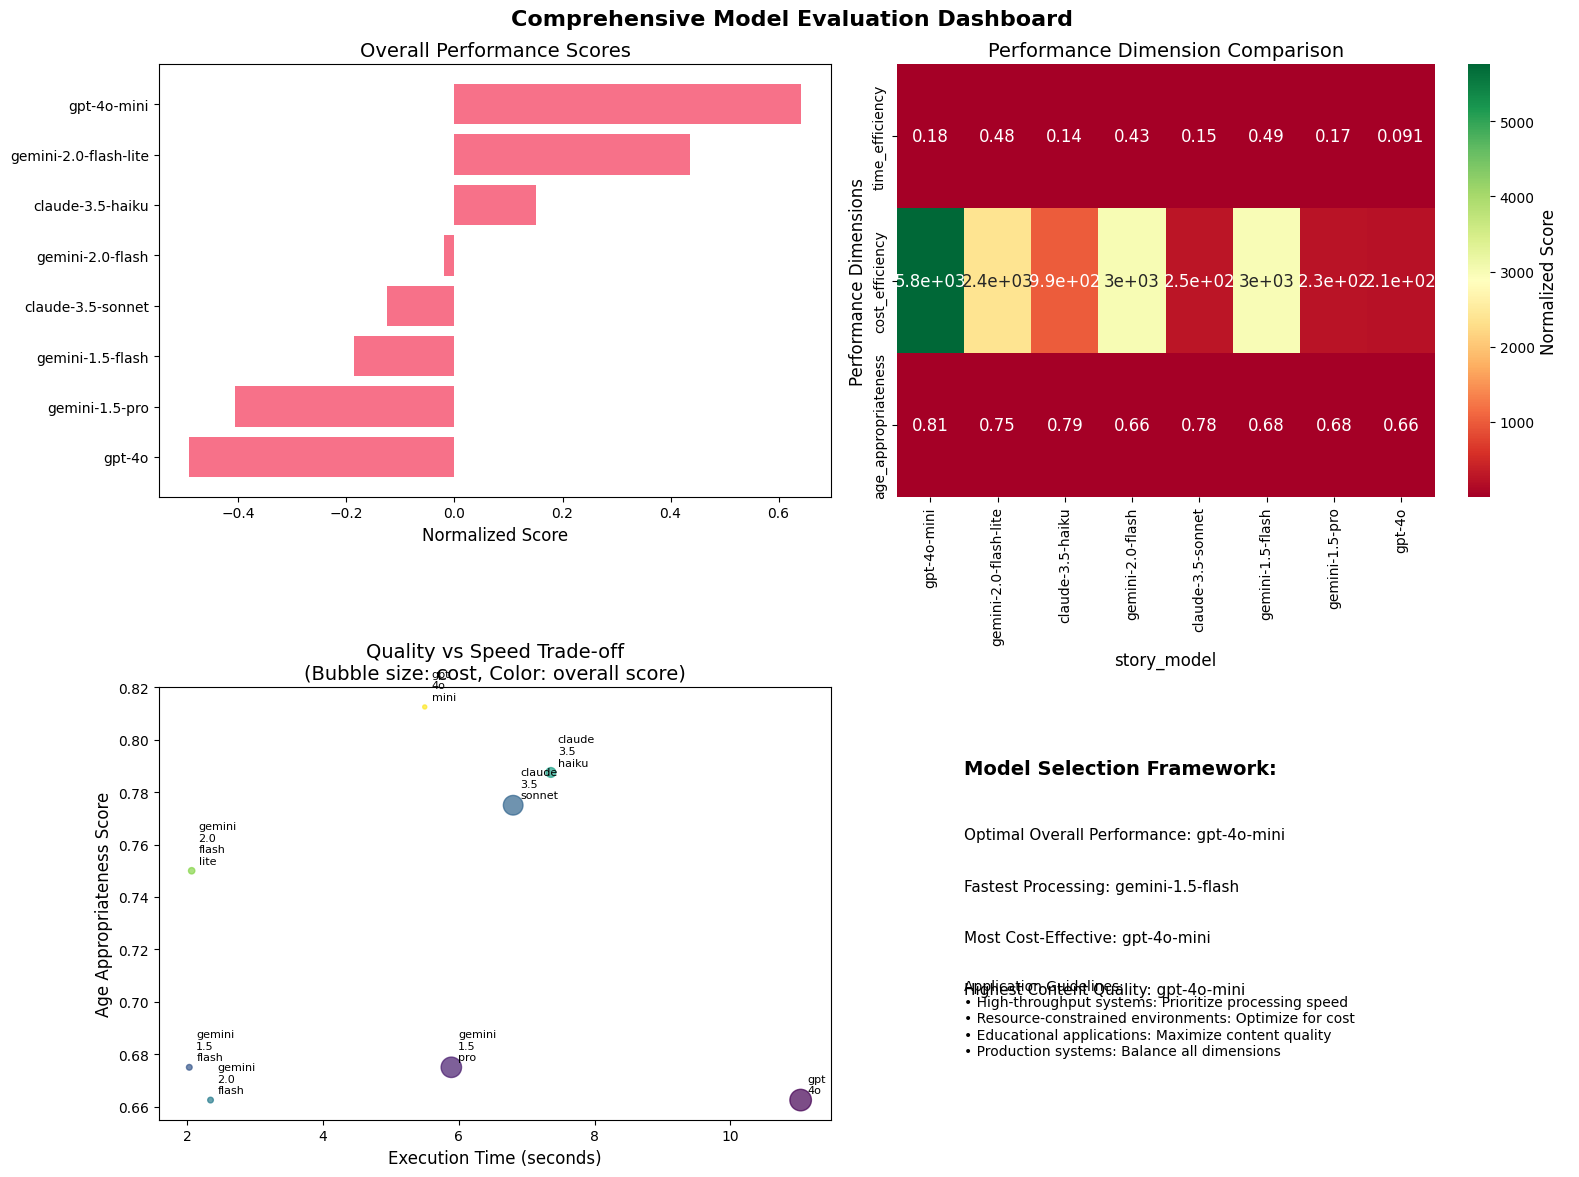


=== RESEARCH SUMMARY ===
Dataset Size: 128 generated stories
Models Evaluated: 8
Test Images: 16
Quality Dimensions Assessed: 20
Performance Metrics: Execution time, cost efficiency, readability, content quality

Methodological Approach:
- Quantitative content analysis using linguistic pattern matching
- Multi-dimensional quality assessment framework
- Statistical normalization and composite scoring
- Comparative performance evaluation across operational and qualitative metrics

This systematic evaluation provides empirical evidence for model selection
in children's educational technology applications, balancing computational
efficiency with pedagogical content quality requirements.


In [12]:
# Create comprehensive evaluation visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive Model Evaluation Dashboard', fontsize=16, fontweight='bold')

# Overall scores comparison
ranking_display_sorted = ranking_display.sort_values('overall_score', ascending=True)
axes[0,0].barh(range(len(ranking_display_sorted)), ranking_display_sorted['overall_score'])
axes[0,0].set_yticks(range(len(ranking_display_sorted)))
axes[0,0].set_yticklabels(ranking_display_sorted['story_model'])
axes[0,0].set_title('Overall Performance Scores')
axes[0,0].set_xlabel('Normalized Score')

# Check available columns for debugging
print("Available columns in ranking_display:", ranking_display.columns.tolist())

# Create simplified score matrix using available columns
# Use basic metrics if the calculated scores aren't available
if 'speed_score' in ranking_display.columns:
    score_cols = ['speed_score', 'cost_score', 'quality_score']
else:
    # Use basic metrics
    score_cols = ['execution_time', 'cost', 'age_appropriateness']
    # Invert time and cost for better visualization (higher = better)
    ranking_display_viz = ranking_display.copy()
    if 'execution_time' in ranking_display_viz.columns:
        ranking_display_viz['time_efficiency'] = 1 / ranking_display_viz['execution_time']
        ranking_display_viz['cost_efficiency'] = 1 / ranking_display_viz['cost']
        score_cols = ['time_efficiency', 'cost_efficiency', 'age_appropriateness']

# Performance metrics components
models = ranking_display['story_model'].values

# Score distribution heatmap using available columns
score_data = ranking_display.set_index('story_model')[score_cols] if 'speed_score' in ranking_display.columns else ranking_display_viz.set_index('story_model')[score_cols]
sns.heatmap(score_data.T, annot=True, cmap='RdYlGn', ax=axes[0,1], cbar_kws={'label': 'Normalized Score'})
axes[0,1].set_title('Performance Dimension Comparison')
axes[0,1].set_ylabel('Performance Dimensions')

# Quality vs Performance trade-off
# Use age_appropriateness as quality metric if quality_score not available
quality_metric = 'quality_score' if 'quality_score' in ranking_display.columns else 'age_appropriateness'
axes[1,0].scatter(ranking_display['execution_time'], ranking_display[quality_metric], 
                 s=ranking_display['cost']*50000, alpha=0.7, c=ranking_display['overall_score'], cmap='viridis')
for i, model in enumerate(ranking_display['story_model']):
    axes[1,0].annotate(model.replace('-', '\n'), 
                      (ranking_display['execution_time'].iloc[i], ranking_display[quality_metric].iloc[i]),
                      xytext=(5, 5), textcoords='offset points', fontsize=8, ha='left')
axes[1,0].set_title('Quality vs Speed Trade-off\n(Bubble size: cost, Color: overall score)')
axes[1,0].set_xlabel('Execution Time (seconds)')
axes[1,0].set_ylabel('Quality Score' if quality_metric == 'quality_score' else 'Age Appropriateness Score')

# Model selection recommendations
recommendations = [
    f"Optimal Overall Performance: {ranking_display.iloc[0]['story_model']}",
    f"Fastest Processing: {ranking_display.loc[ranking_display['execution_time'].idxmin(), 'story_model']}",
    f"Most Cost-Effective: {ranking_display.loc[ranking_display['cost'].idxmin(), 'story_model']}",
    f"Highest Content Quality: {ranking_display.loc[ranking_display['age_appropriateness'].idxmax(), 'story_model']}"
]

axes[1,1].text(0.1, 0.8, "Model Selection Framework:", fontsize=14, fontweight='bold', transform=axes[1,1].transAxes)
for i, rec in enumerate(recommendations):
    axes[1,1].text(0.1, 0.65 - i*0.12, rec, fontsize=11, transform=axes[1,1].transAxes)

axes[1,1].text(0.1, 0.15, "Application Guidelines:\n• High-throughput systems: Prioritize processing speed\n• Resource-constrained environments: Optimize for cost\n• Educational applications: Maximize content quality\n• Production systems: Balance all dimensions", 
               fontsize=10, transform=axes[1,1].transAxes)
axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(0, 1)
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

print("\n=== RESEARCH SUMMARY ===")
print(f"Dataset Size: {len(df)} generated stories")
print(f"Models Evaluated: {df['story_model'].nunique()}")
print(f"Test Images: {df['image_file'].nunique()}")
print(f"Quality Dimensions Assessed: {len(all_indicators)}")
print(f"Performance Metrics: Execution time, cost efficiency, readability, content quality")
print(f"\nMethodological Approach:")
print(f"- Quantitative content analysis using linguistic pattern matching")
print(f"- Multi-dimensional quality assessment framework")
print(f"- Statistical normalization and composite scoring")
print(f"- Comparative performance evaluation across operational and qualitative metrics")
print(f"\nThis systematic evaluation provides empirical evidence for model selection")
print(f"in children's educational technology applications, balancing computational")
print(f"efficiency with pedagogical content quality requirements.")
